In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !git clone https://github.com/Lenkus1/HuubS_ML_Opdracht.git
    %cd HuubS_ML_Opdracht/template
    #%pip install loguru
    %pip install -q -U keras-tuner

In [2]:
%load_ext autoreload
%autoreload 2

#%pip install keras-tuner


from pathlib import Path
import os
import sys
sys.path.insert(0, "..")
sys.path

import numpy as np
import seaborn as sns
sns.set_theme()

import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import keras_tuner as kt


#data_set = "/content/HuubS_ML_Opdracht/template/src/data/"

#from HuubS_ML_Opdracht.template.src.data import make_dataset


#from HuubS_ML_Opdracht.template.src.visualization import visualize_simple





In [3]:
datadir_processed = Path("../data/processed")
datadir_model = Path("../models")

if IS_COLAB:
    datadir_processed = "/content/HuubS_ML_Opdracht/template/data/processed"
    datadir_model = "/content/HuubS_ML_Opdracht/template/models"

In [4]:
from typing import Dict, List, Tuple

def cfm_heatmap(
    cfm: np.ndarray,
    figsize: tuple = (8, 8),
    scale: float = None,
    labels: List[str] = None,
    vmin: float = None,
    vmax: float = None,
) -> None:
    """
    figsize: tuple, default (8,8)
    scale: string. The direction over which the numbers are scaled.
        Either None, 'total', 'rowwise' or 'colwise'
    """

    if scale == "total":
        cfm_norm = cfm / np.sum(cfm)
    elif scale == "rowwise":
        cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
    elif scale == "colwise":
        cfm_norm = cfm / np.sum(cfm, axis=0, keepdims=True)
    else:
        cfm_norm = cfm
    plt.figure(figsize=figsize)
    if labels is not None:
        plot = sns.heatmap(
            cfm_norm,
            annot=cfm_norm,
            vmin=vmin,
            vmax=vmax,
            xticklabels=labels,
            yticklabels=labels,
        )
    else:
        plot = sns.heatmap(cfm_norm, annot=cfm_norm, vmin=vmin, vmax=vmax)
    plot.set(xlabel="Predicted", ylabel="Target")


In [5]:
data = []
labels = []

for f in sorted(os.listdir(datadir_processed)):
    folder = os.path.join(datadir_processed, f)
    if os.path.isdir(folder):
        #print(f"{f} is a target class")
        for i in sorted(os.listdir(folder)):
            image=tf.keras.preprocessing.image.load_img(folder+'/'+i, 
            target_size= (64,64))
            image=np.array(image)
            data.append(image)
            labels.append(f)

data = np.array(data)
#labels = np.array(labels)
labels = list(labels)
#labels_text = labels
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
#labels = to_categorical(labels)



X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.125,
                                                random_state=42)




# Pre-processing
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255
X_valid = X_valid.astype('float32') / 255

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)


(12414, 64, 64, 3)
(3548, 64, 64, 3)
(1774, 64, 64, 3)


In [12]:
from kerastuner import HyperModel

INPUT_SHAPE = (64, 64, 3)
NUM_CLASSES = 10



class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        
        KS=hp.Choice('num_kernels',values=[3, 5, 7], default=5)
        KI='he_uniform'
        KR=regularizers.l2(hp.Float('l2', min_value=0.001, max_value=0.005, default=0.002, step=0.001))
      
        data_augmentation = tf.keras.Sequential([
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(-0.2, 0.2),
        keras.layers.RandomTranslation(-0.1, 0.1),
        keras.layers.RandomZoom(-0.2, 0.2)
        ])

        
        model = keras.Sequential()

        #model.add(keras.layers.Cropping2D(cropping=((15, 15), (15, 15)), input_shape=INPUT_SHAPE))

        data_augmentation

        keras.layers.RandomCrop
        keras.layers.RandomRotation
        keras.layers.RandomZoom
        keras.layers.RandomTranslation
        keras.layers.RandomFlip

        model.add(keras.layers.Conv2D(filters=hp.Choice('num_filters_1', values=[32, 64, 96, 128], default=32), kernel_size=KS,kernel_initializer=KI, kernel_regularizer=KR, input_shape=self.input_shape))
        model.add(keras.layers.Conv2D(filters=hp.Choice('num_filters_2', values=[32, 64, 96, 128], default=32), kernel_size=KS,kernel_regularizer=KR))
        model.add(keras.layers.LeakyReLU(alpha=0.2))
        model.add(keras.layers.MaxPooling2D(pool_size=2))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
       
        model.add(keras.layers.Conv2D(filters=hp.Choice('num_filters_3', values=[32, 64, 96, 128], default=64), kernel_size=KS,kernel_regularizer=KR))
        model.add(keras.layers.Conv2D(filters=hp.Choice('num_filters_4', values=[32, 64, 96, 128], default=64), kernel_size=KS,kernel_regularizer=KR))
        model.add(keras.layers.LeakyReLU(alpha=0.2))
        model.add(keras.layers.MaxPooling2D(pool_size=2))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

       
        model.add(keras.layers.Conv2D(filters=hp.Choice('num_filters_5', values=[32, 64, 96, 128], default=64), kernel_size=KS,kernel_regularizer=KR))
        model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32, default=128), activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu'),kernel_regularizer=KR))
        model.add(keras.layers.Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(keras.layers.Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=16, default=64), activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu'),kernel_regularizer=KR))
        model.add(keras.layers.Dropout(rate=hp.Float('dropout_4', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(keras.layers.Dense(self.num_classes, activation='softmax'))

        
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

In [13]:
from kerastuner.tuners import Hyperband

tuner = kt.Hyperband(
    hypermodel,
    overwrite=True,
    objective='val_accuracy',
    max_epochs=20,
    executions_per_trial=1,
    hyperband_iterations=1,
    directory=datadir_model,
    project_name='galaxies'
    )


In [14]:
tuner.search_space_summary()

Search space summary
Default search space size: 18
num_filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 96, 128], 'ordered': True}
num_kernels_1 (Choice)
{'default': 5, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
num_filters_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 96, 128], 'ordered': True}
num_kernels_2 (Choice)
{'default': 5, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
num_filters_3 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64, 96, 128], 'ordered': True}
num_kernels_3 (Choice)
{'default': 5, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
num_filters_4 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64, 96, 128], 'ordered': True}
num_kernels_4 (Choice)
{'default': 5, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
dropout_2 (Float)
{'default': 0.25, 'co

In [15]:
tuner.search(X_train, y_train,
             validation_data=(X_valid, y_valid),
             batch_size=32,
             #epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=2)])


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
num_filters_1     |128               |?                 
num_kernels_1     |3                 |?                 
num_filters_2     |96                |?                 
num_kernels_2     |3                 |?                 
dropout_1         |0.1               |?                 
num_filters_3     |32                |?                 
num_kernels_3     |7                 |?                 
num_filters_4     |32                |?                 
num_kernels_4     |7                 |?                 
dropout_2         |0.3               |?                 
num_filters_5     |128               |?                 
num_kernels_5     |7                 |?                 
units_1           |96                |?                 
dense_activation  |sigmoid           |?                 
dropout_3         |0.45              |?                 
units_2           |80                |?                 
drop

In [ ]:
# Show a summary of the search
tuner.results_summary()

Results summary
Results in ..\models\galaxies
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_filters_1: 64
num_filters_2: 32
num_filters_3: 32
dropout_1: 0.15000000000000002
units_1: 160
dense_activation: tanh
dropout_2: 0.25
units_2: 96
dropout_3: 0.45
learning_rate: 0.0006570805207624917
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6499436497688293
Trial summary
Hyperparameters:
num_filters_1: 32
num_filters_2: 64
num_filters_3: 32
dropout_1: 0.30000000000000004
units_1: 192
dense_activation: relu
dropout_2: 0.45
units_2: 96
dropout_3: 0.1
learning_rate: 0.001413751920126406
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: dcbc4e070148bf55fa7f8e19c74c01ad
Score: 0.6465614438056946
Trial summary
Hyperparameters:
num_filters_1: 32
num_filters_2: 32
num_filters_3: 32
dropout_1: 0.05
units_1: 224
dense_activation: tanh
dropout_2: 0.15000000000000002
units_

In [12]:
best_hps=tuner.get_best_hyperparameters()[0]

In [13]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

Epoch 1/20
388/388 [==============================] - 25s 63ms/step - loss: 1.8198 - accuracy: 0.3298 - val_loss: 1.5009 - val_accuracy: 0.4431
Epoch 2/20
388/388 [==============================] - 24s 63ms/step - loss: 1.4613 - accuracy: 0.4691 - val_loss: 1.3427 - val_accuracy: 0.5017
Epoch 3/20
388/388 [==============================] - 24s 61ms/step - loss: 1.2905 - accuracy: 0.5430 - val_loss: 1.2468 - val_accuracy: 0.5547
Epoch 4/20
388/388 [==============================] - 24s 61ms/step - loss: 1.1714 - accuracy: 0.5910 - val_loss: 1.2032 - val_accuracy: 0.5789
Epoch 5/20
388/388 [==============================] - 24s 62ms/step - loss: 1.0654 - accuracy: 0.6356 - val_loss: 1.0936 - val_accuracy: 0.6257
Epoch 6/20
388/388 [==============================] - 24s 63ms/step - loss: 0.9837 - accuracy: 0.6618 - val_loss: 1.0710 - val_accuracy: 0.6302
Epoch 7/20
388/388 [==============================] - 25s 64ms/step - loss: 0.9017 - accuracy: 0.6921 - val_loss: 1.0821 - val_accuracy:

In [14]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, y_test)

111/111 [==============================] - 2s 15ms/step - loss: 1.1331 - accuracy: 0.6395


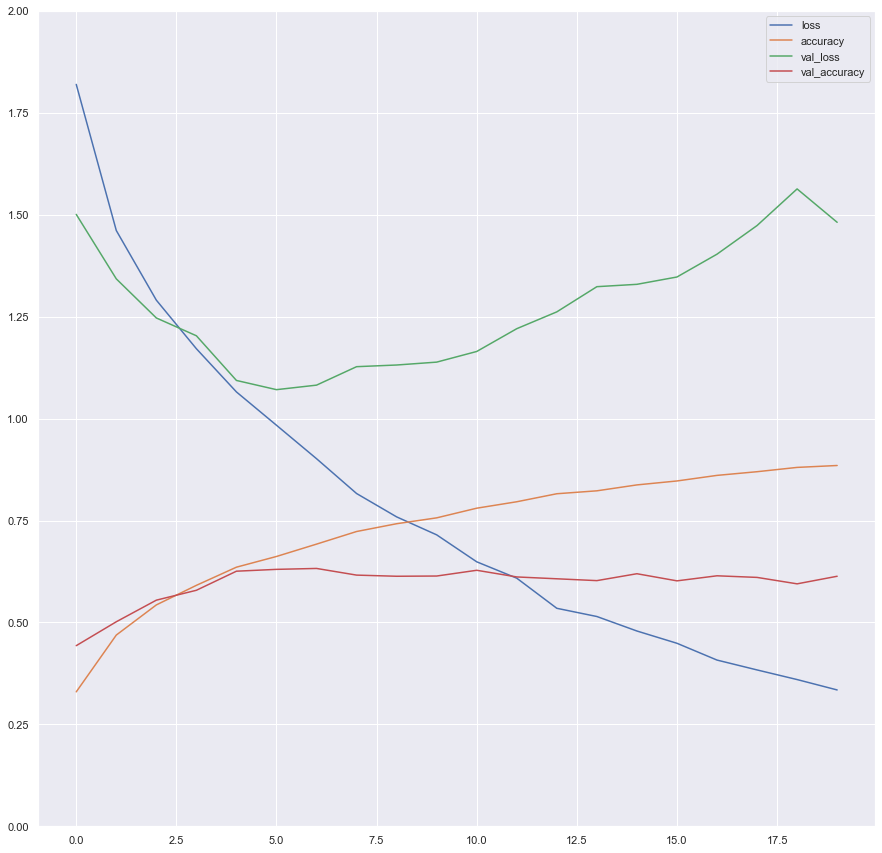

In [15]:
pd.DataFrame(history.history).plot(figsize=(15, 15))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-2]
plt.show()

In [16]:
#y_test = np.argmax(y_test,axis=1)
predict = best_model.predict(X_test).argmax(axis=1)


In [17]:
#encoder = LabelEncoder()
#y_test = encoder.fit_transform(y_test)
#predict = encoder.fit_transform(predict)

print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61       393
           1       0.44      0.38      0.41        68
           2       0.32      0.18      0.23       218
           3       0.74      0.82      0.78       378
           4       0.75      0.86      0.80       279
           5       0.57      0.57      0.57       380
           6       0.84      0.83      0.83       563
           7       0.68      0.72      0.70       399
           8       0.44      0.53      0.48       516
           9       0.62      0.51      0.56       354

    accuracy                           0.64      3548
   macro avg       0.60      0.60      0.60      3548
weighted avg       0.63      0.64      0.63      3548



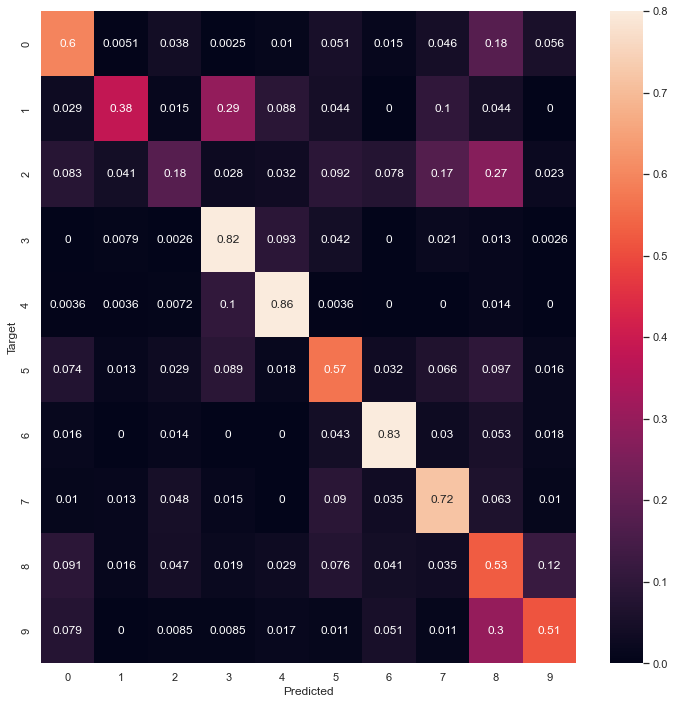

In [18]:
cfm = confusion_matrix(y_test, predict)
cfm_heatmap(cfm, figsize=(12,12), scale='rowwise', vmax= 0.8)


